In [10]:
import ot
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import math
import csv

In [167]:
# Load images
# Define path to the data directory
data_dir = Path('/Users/carollong/Desktop/OptimalTransport/ShapeProject/Data/pointclouds')
all_dir = [f for f in data_dir.glob("*.*")]
print(len(all_dir))
# Reshaped to size dim x dim 
# dim = 128, then sample 3000 points from each image

all_img = []
# Process each img
for i in range(len(all_dir)):
    direc = all_dir[i]
    with open(direc, newline='') as csvfile:
        data = csv.reader(csvfile)
        temp = []
        for row in data:
            temp.append(row)
        all_img.append(temp)

# Shuffle lists
random.shuffle(all_img)
print(np.array(all_img).shape)
all_img = np.array(all_img, dtype=np.float32)

99
(99, 2, 3000)


In [168]:
# Test
vectormatrix = [] #N*2
for i in range(5):
    #random direction in the unit circle
    theta = random.uniform(0,2*math.pi)
    x = math.cos(theta)
    y = math.sin(theta)
    vectormatrix.append([x,y])
print(np.array(vectormatrix).shape)
#vectormatrix = np.transpose(np.array(vectormatrix)) #2*N

(5, 2)


In [92]:
# Test
in_arr = np.array([[ 5, 0, 1],[ 1, 0, 5]])  #2*3
index = np.argsort(in_arr,axis = 1)
print(index)
arr1 = np.array([[1,2,3], [ 4, 5,6]]) #2*3
# print(arr1[:,index[i]])

arr2 = np.array([1,2,3,4,5])
y = np.tile(arr2, (2,1))

vc = np.array([1,2])
vc = np.tile(vc,(5,1))
vc = np.transpose(vc)
print(vc)
print(vc*y)

[[1 2 0]
 [1 0 2]]
[[1 1 1 1 1]
 [2 2 2 2 2]]
[[ 1  2  3  4  5]
 [ 2  4  6  8 10]]


In [169]:
def sliced_W2_distance(source,target,N):
    '''
    source (img): 2 * 3000 
    target (barycenter): 2 * 3000 
    N: sample N directions
    '''
    vectormatrix = [] #N*2 
    for i in range(N):
        #random direction in the unit circle
        theta = random.uniform(0,2*math.pi)
        x = math.cos(theta)
        y = math.sin(theta)
        vectormatrix.append([x,y])
    vectormatrix = np.array(vectormatrix,dtype=np.float32)
    projSource = np.matmul(vectormatrix,source) #N*3000
    projTarget = np.matmul(vectormatrix,target) #N*3000

    # sort the 3000 points N times
    projSourceVal = np.sort(projSource,axis=1) #N*3000
    projTargetVal = np.sort(projTarget,axis=1)#N*3000
   
    projTargetIdx = np.argsort(projTarget,axis=1) #N*3000
    #Frobenius norm
    dist = np.linalg.norm(np.array(projSource)-np.array(projTarget))
    dist = dist**2
    # return gradient as well (if loop)
    diff = projSourceVal-projTargetVal #N*3000
    dx = np.zeros((2,3000))
    for i in range(len(diff)):
        #1*3000 diff, ith direction 
        direction = vectormatrix[i] # 1*2
        direction = np.tile(direction,(3000,1))
        direction = np.transpose(direction)
        curDiff = diff[i] # 1*3000
        curDiff = np.vstack((curDiff,curDiff)) #2*3000
        # dot product with broadcast
        curDiff = np.multiply(curDiff,direction) #2*3000
        # rearrange columns according to index
        dx += curDiff[:,projTargetIdx[i]]
    return dist, dx/N

In [99]:
#Test
print(all_img[0].shape)
print(all_img[1].shape)
dist, grad = sliced_W2_distance(all_img[0],all_img[1],100)
print(dist)
print(grad)

(2, 3000)
(2, 3000)
239858300.4104004
[[ 3.47186295  3.11400842  2.9776369  ...  2.76891779  3.36160012
   3.8251074 ]
 [-2.43467333 -2.82177116 -2.0877431  ... -2.55068596 -1.63739291
  -2.73840583]]


In [170]:
# Initialize k centroids of size 2 x 3000, by picking k samples randomly
# Number of clusters
k = 9
# Randomly pick k centroids from dataset
np.random.seed = 5
rdm_idx = np.random.choice(range(all_img.shape[0]), k, replace=False)
W = all_img[rdm_idx,:,:]
print("W shape:", W.shape)

W shape: (9, 2, 3000)


In [171]:
# assign clusters
def expectation(X, W):
    '''
    X: N x 2 x 3000 image point clouds
    W: k x 2 x 3000 barycenter point clouds
    dist: "euclidean" or "wasserstein"
    '''
    # Get shapes
    N = X.shape[0]
    k = W.shape[0]
#     if dist == "wasserstein":
    # Compute Distance and assign cluster in one step
    cluster_id = [] # N x 1
    # Compute distances from each sample to each cluster 
    for i in range(N):
        minDist = float('inf')
        index = -1
        for j in range(k):
            tempdist, grad = sliced_W2_distance(X[i],W[j],100)
            if tempdist<minDist:
                minDist = tempdist
                index = j
        cluster_id.append(index)

    cluster_id = np.array(cluster_id)
#         print(cluster_id.shape)
#     else:
#         # Reshape inputs to use broadcasting
#         X_exp = X.reshape(N, 1, d)  
#         W_exp = W.reshape(1, k, d) 
#         # Compute distances from each sample to each cluster
#         distances = np.linalg.norm(X_exp - W_exp, axis=2) # N x k
#         # Obtain cluster assignements
#         cluster_id = np.argmin(distances, axis=1)
        
    # Matrix of one-hot vectors
    Z = np.zeros((N, k))
    Z[range(N),cluster_id] = 1 
    return Z

In [172]:
def maximization(X, Z, W):
    '''
    X: N x 2 x 3000 image point clouds
    W: k x 2 x 3000 barycenter point clouds
    Z: N x k
    dist: "euclidean" or "wassersten"
    '''
    
    # Get shapes
    N = X.shape[0]
    k = Z.shape[1]
    # Compute updated centroids
    W_new = np.zeros((k, 2,3000))
#     if dist == "wasserstein":
    # every class (barycenter)
    for cl_id in range(k):
        W_old = W[cl_id,:,:]
        # every point cloud belonging to that class
        tempClass = X[(Z[: ,cl_id] == 1), :]
        dx = np.zeros((2,3000)) 
        for sample in tempClass:
            dist, grad = sliced_W2_distance(sample,W_old,100)
            dx +=grad
        dx/=len(tempClass)
        W_old+=dx
        W_new[cl_id,:,:]=W_old

#     else:
#     for cl_id in range(k):
#         W_new[cl_id, :,:] = np.mean(X[(Z[: ,cl_id] == 1), :,:], axis=0)
    return W_new

In [178]:
def run_kmeans(X, K, max_iter = 10, eps = 1e-5, log_interval = 2):
   
    # Randomly pick k centroids from dataset
    np.random.seed = 5
    rdm_idx = np.random.choice(range(X.shape[0]), K, replace=False)
    W = X[rdm_idx,:,:]
    Z = None
    
    # Expectation-maximization loop
    for n_iter in range(max_iter):
        # Store previous W and Z
        Z_prev = Z
        W_prev = W
        
        # Expectation followed by maximization step
        Z = expectation(X, W)
        W = maximization(X, Z,W)

        # Terminate if change in Z and W is small
        if Z_prev is not None and ((Z_prev - Z) ** 2).sum() < eps and ((W_prev - W) ** 2).sum() < eps:
            print('Done at iteration: ', n_iter + 1)
            #rec_error = np.linalg.norm(X - Z @ W).sum() 
            #print ('Reconstruction error ', n_iter + 1,":", rec_error)
            break

        # Print reconstruction loss every log_interval steps    
#         if (n_iter + 1) % log_interval == 0 or (n_iter + 1) == max_iter or n_iter == 0:
            #rec_error = np.linalg.norm(X - Z @ W).sum()
            #print ('Reconstruction error at iteration ', n_iter + 1,":", rec_error)
            
    # Visualize with Wasserstein barycenter. 
    
    return W, Z

In [179]:
W, Z = run_kmeans(all_img, K=9)

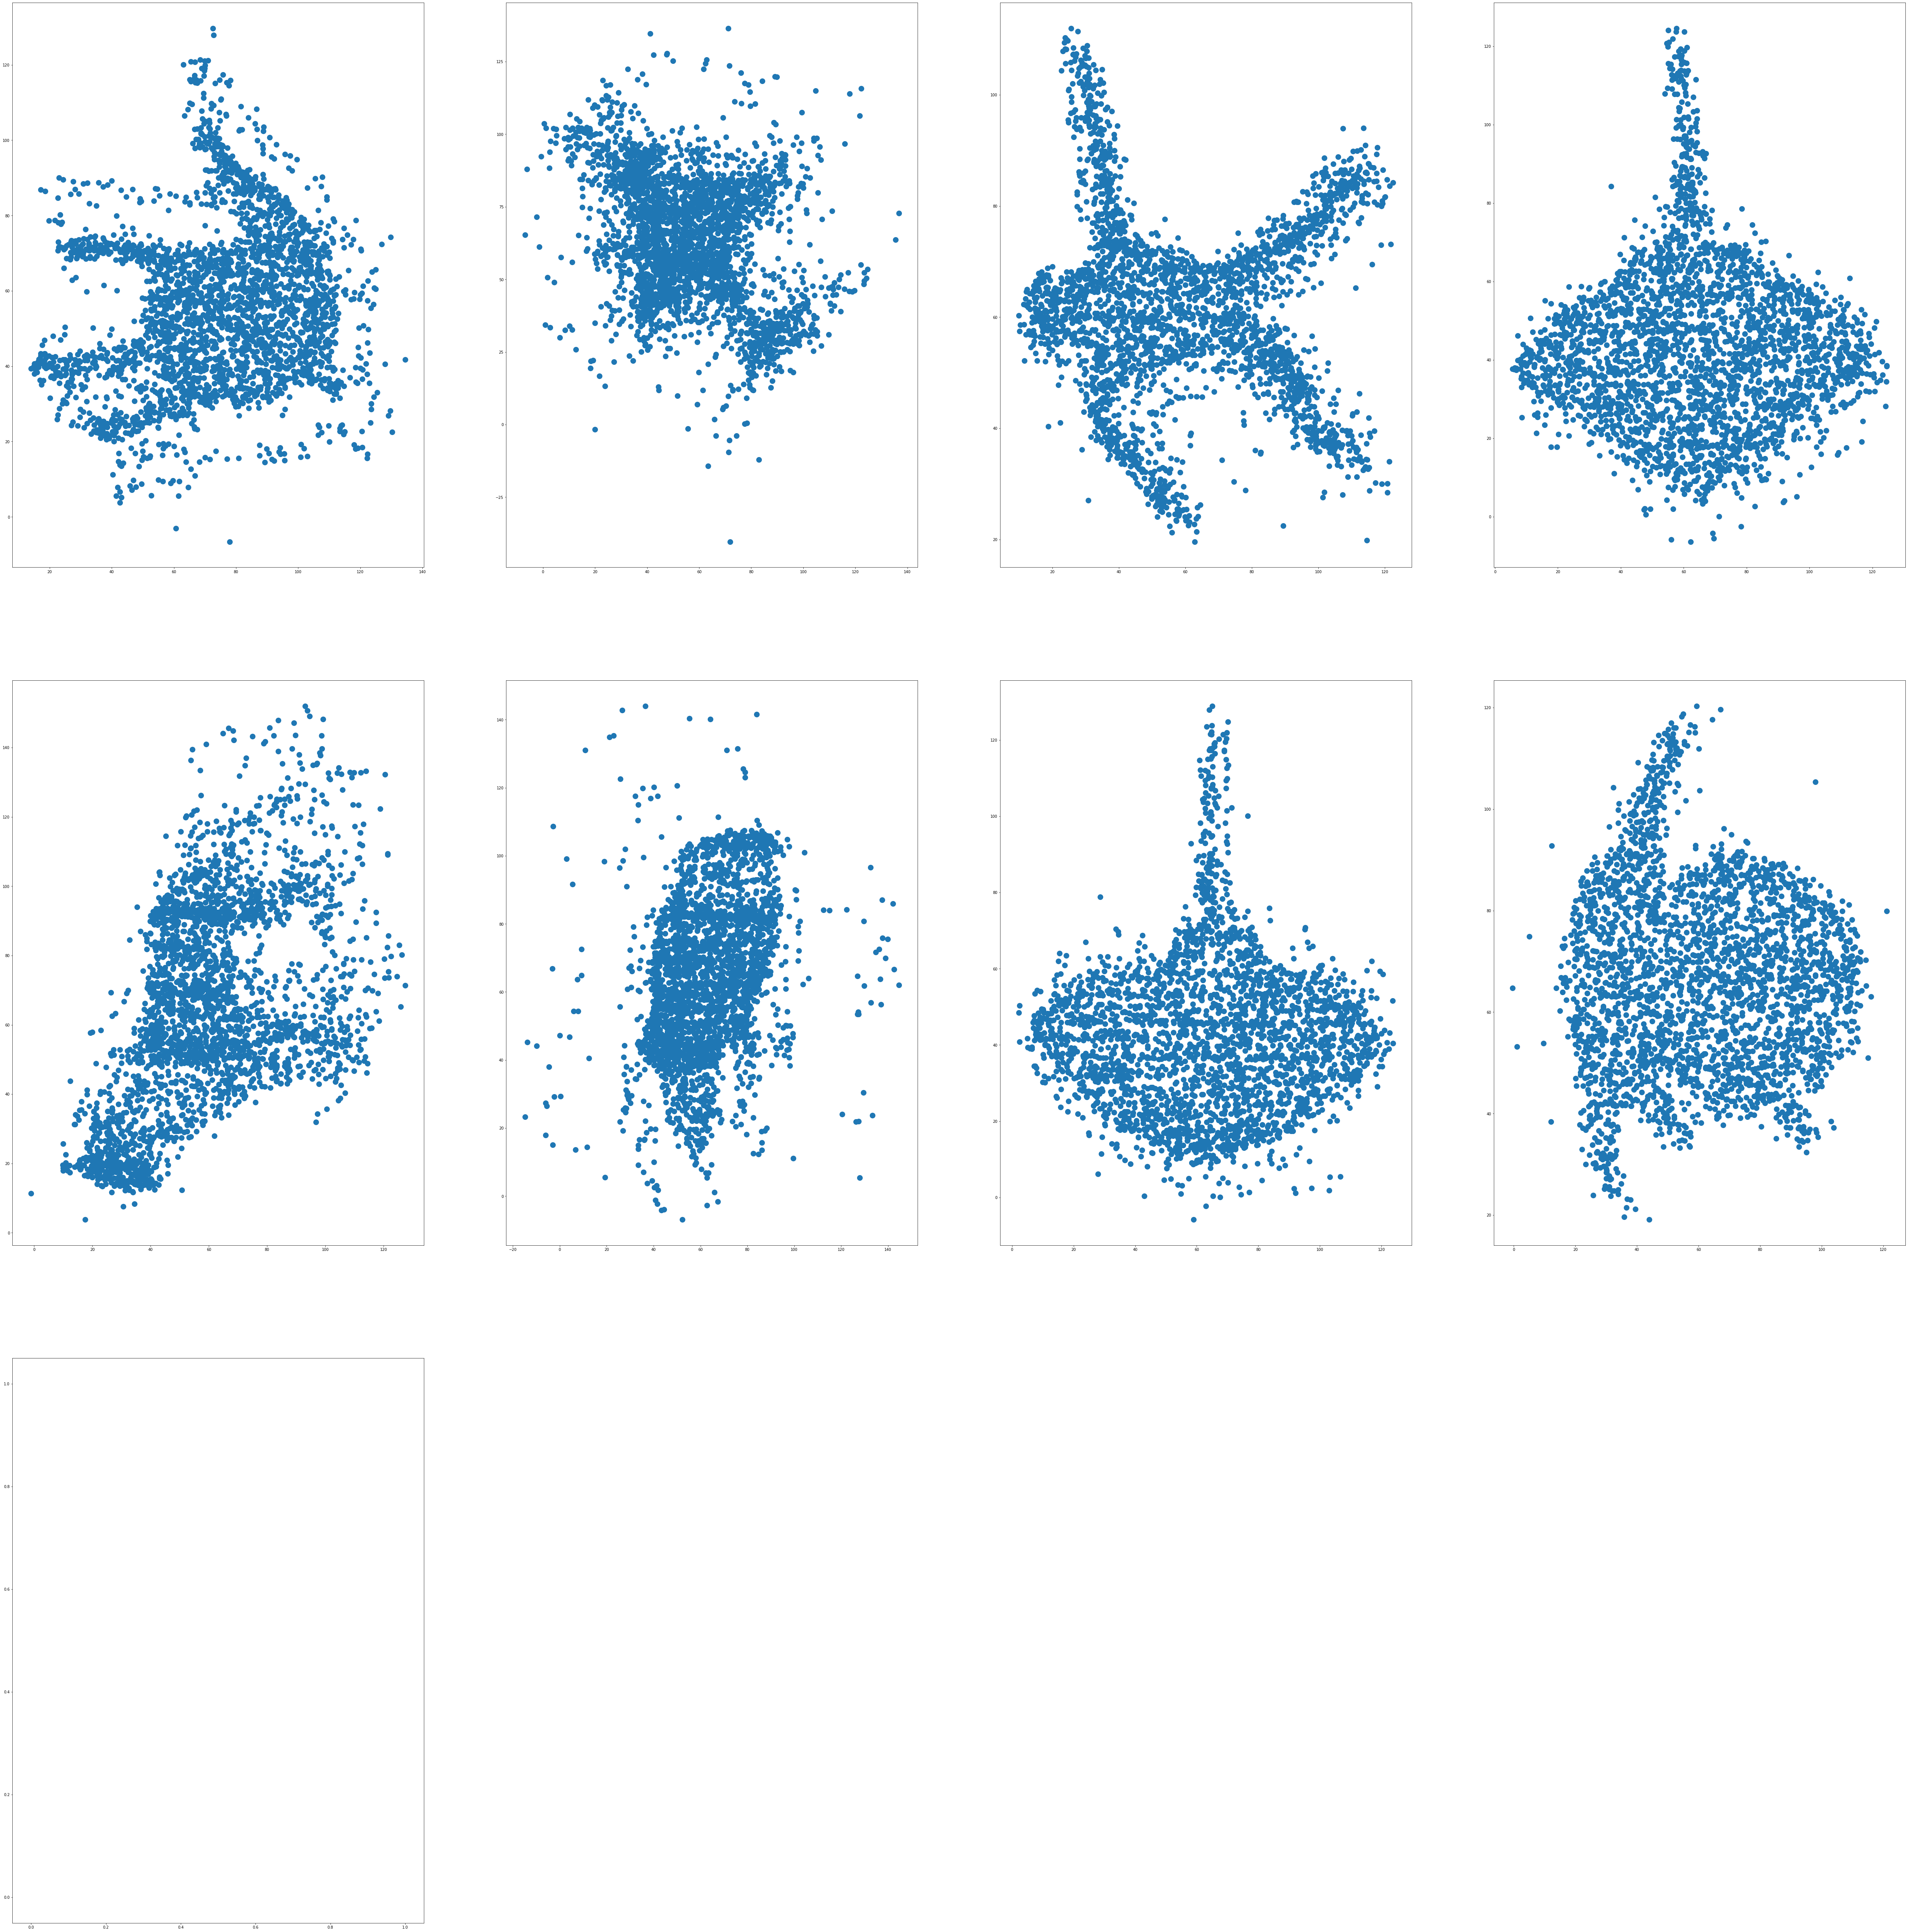

In [177]:
# visualize euclidean centroid
# Reshaping input data back
plt.figure(figsize = (128,128))
bottom = 0.35
for i in range(k):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    x = W[i][0]
    y = W[i][1]
    plt.scatter(x, y, s= 200)

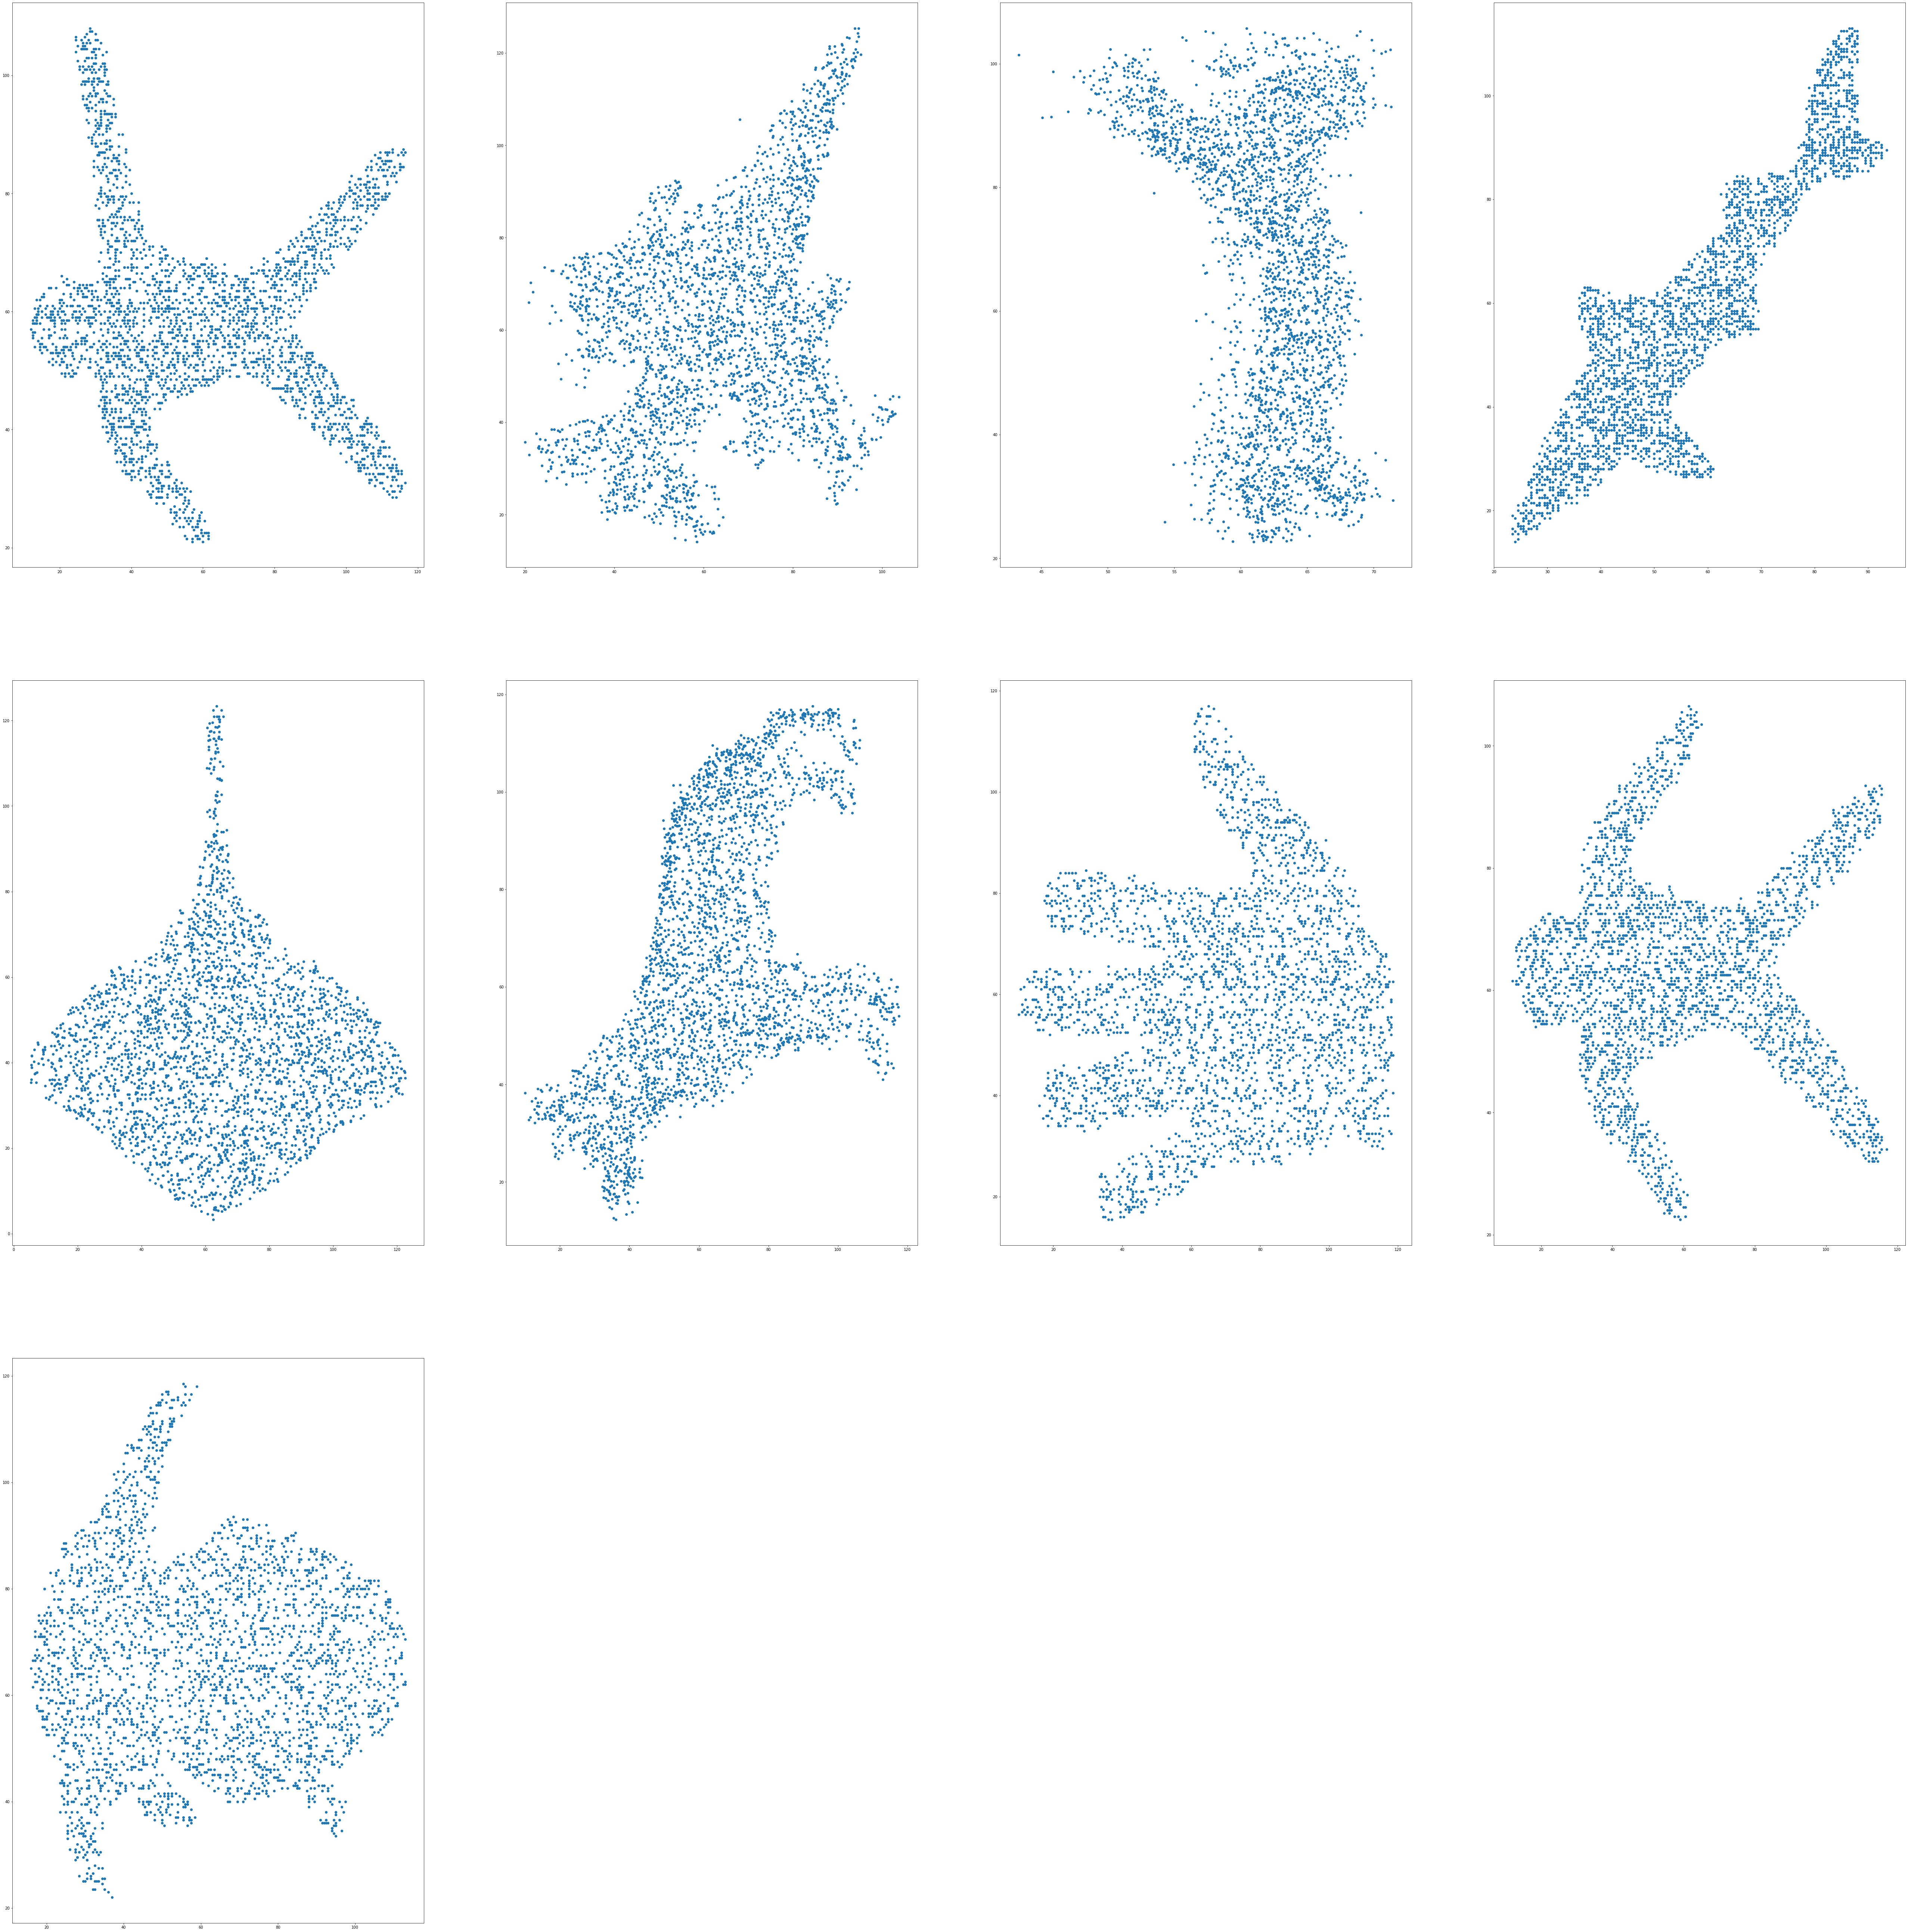

In [166]:
# visualize euclidean centroid
# Reshaping input data back
plt.figure(figsize = (128,128))
bottom = 0.35
for i in range(k):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    x = W[i][0]
    y = W[i][1]
    plt.scatter(x, y, s=200,c=z)

In [137]:
print(W[0][0].shape)

(3000,)


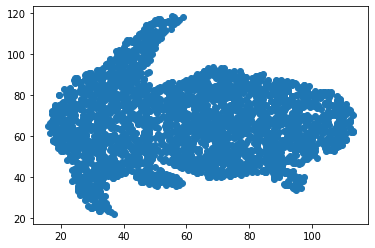

In [152]:
import numpy as np
import matplotlib.pyplot as plt

x = W[8][0]
y = W[8][1]

plt.scatter(x, y)
plt.show()